In [ ]:
#Rusbhi Abel - 220711744 - Tensorflow - Klasfiikasi Gambar Kunyit, Jahe, dan Lengkuas - GoogleNet

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [8]:
count = 0
dirs = os.listdir(r'C:\Users\ASUS\Documents\dataset\Google net\train')
for i in dirs:
    files = list(os.listdir(r'C:\Users\ASUS\Documents\dataset\Google net\train' + '/' + i))
    count += len(files)
    print(i + ' Folder has ' + str(len(files)) + ' images')
print('Total images in train folder: ', count)

jahe Folder has 100 images
kunyit Folder has 100 images
lengkuas Folder has 100 images
Total images in train folder:  300


In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = r"C:\Users\ASUS\Documents\dataset\Google net\train"
validation_dir = r"C:\Users\ASUS\Documents\dataset\Google net\validation"
test_dir = r"C:\Users\ASUS\Documents\dataset\Google net\test" 

os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

categories = [name for name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, name))]

validation_split = 0.1  # 10% untuk validasi
test_split = 0.1        # 10% untuk test
train_split = 1 - validation_split - test_split  # 80% untuk train

for category in categories:
    category_dir = os.path.join(base_dir, category)
    validation_category_dir = os.path.join(validation_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    
    os.makedirs(validation_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)
    
    all_files = os.listdir(category_dir)
    
    train_val_files, test_files = train_test_split(all_files, test_size=test_split, random_state=42)
    
    train_files, val_files = train_test_split(train_val_files, test_size=validation_split / (train_split + validation_split), random_state=42)
    
    for file in val_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(validation_category_dir, file))
    
    for file in test_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(test_category_dir, file))

print("Dataset berhasil dibagi menjadi train, validation, dan test!")


Dataset berhasil dibagi menjadi train, validation, dan test!


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    r'train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    r'validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    r'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


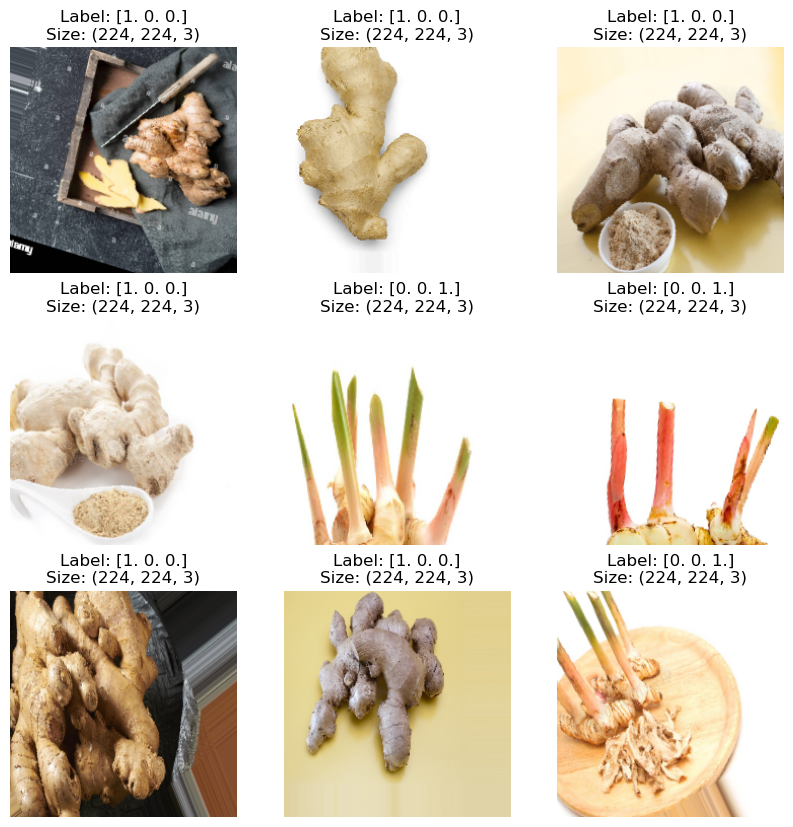

In [12]:
sample_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(min(9, len(sample_batch[0]))):
    image = sample_batch[0][i]
    label = sample_batch[1][i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}\nSize: {image.shape}")
    plt.axis('off')
plt.show()

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.models import Model

def inception_block(x, filters):
    conv_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv_3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv_3x3_reduce)

    conv_5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv_5x5_reduce)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)

    return output


In [14]:
def googlenet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])

    x = AveragePooling2D((7, 7), strides=(1, 1))(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(input_layer, output_layer)
    return model


In [15]:
model = googlenet((224, 224, 3), num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks=[early_stopping])


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3866 - loss: 1.8479 - val_accuracy: 0.4333 - val_loss: 1.1568
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3892 - loss: 1.1270 - val_accuracy: 0.5333 - val_loss: 0.9242
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5468 - loss: 0.9119 - val_accuracy: 0.4667 - val_loss: 1.1613
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5073 - loss: 0.9402 - val_accuracy: 0.5667 - val_loss: 0.7686
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5826 - loss: 0.8259 - val_accuracy: 0.6333 - val_loss: 0.6487
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6078 - loss: 0.8279 - val_accuracy: 0.6333 - val_loss: 0.6441
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6096 - loss: 0.8026 - val_accuracy: 0.6333 - val_loss: 0.6737
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5422 - loss: 0.7729 - val_accuracy: 0.6333 - val_loss: 0.6276
Epoch 9/50
8/8 ━━━━

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 0.7099
Test Loss: 0.709863007068634
Test Accuracy: 0.6000000238418579


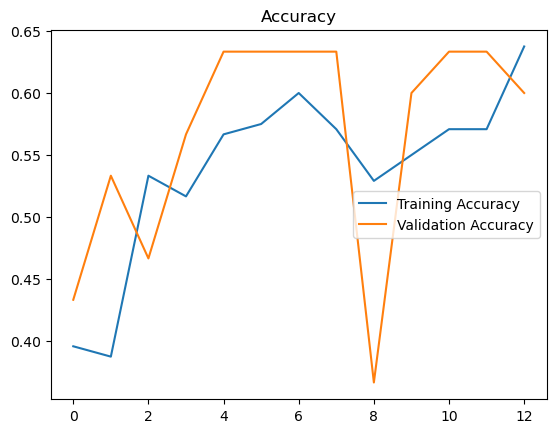

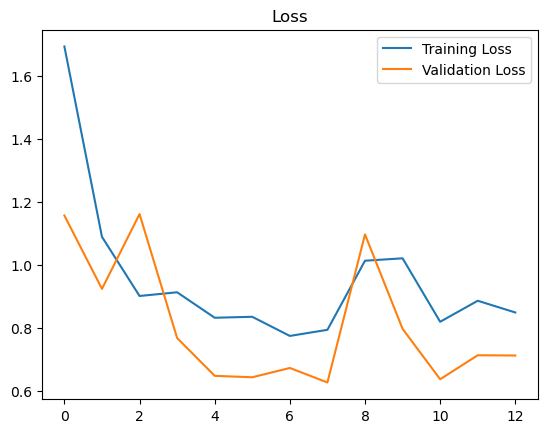

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()


In [17]:
model.save('googleNet_model.h5')

Found 30 images belonging to 3 classes.


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 0.7099
Test Loss: 0.709863007068634
Test Accuracy: 0.6000000238418579
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


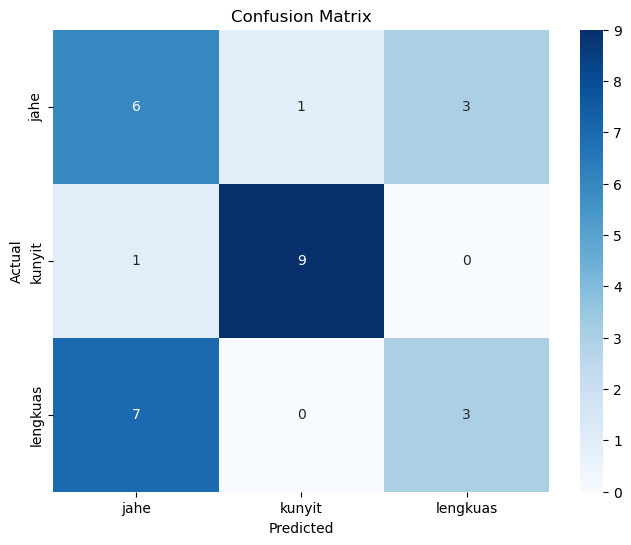

Classification Report:
              precision    recall  f1-score   support

        jahe       0.43      0.60      0.50        10
      kunyit       0.90      0.90      0.90        10
    lengkuas       0.50      0.30      0.38        10

    accuracy                           0.60        30
   macro avg       0.61      0.60      0.59        30
weighted avg       0.61      0.60      0.59        30



In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model = load_model('googleNet_model.h5')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)
